In [2]:
import os
wd = os.getcwd()
wd = os.path.dirname(wd)
import sys
sys.path.append(wd+"\\src\\")

In [3]:
from tube import InterpXY,Tube,BorderSimple
from math import *
import numpy as np
from gaslayer import GasEOS, GasLayer
import pprint as pp

In [4]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

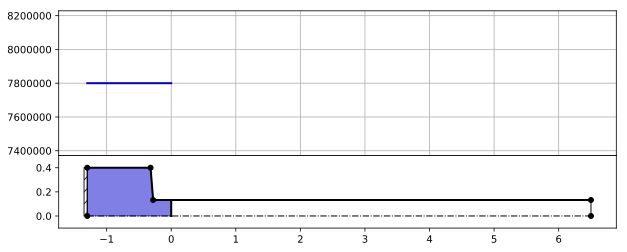

Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=7.8 MPa
layers:
0) GasLayer(n_cells=2000); 
        {'p_max':7800000.0, 'tau_min': 1.8948633523486626e-06, 
        'u_max': 0.0, 'cs_max': 343.03265150711235, 'dx_min': 0.0006499999999998174, 
        'x_1': -1.3, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }

In [29]:
sandwich_dict_sample = {
    'tube': {
        'tube_points': [[-1.3, 0.8], [-0.32, 0.8], [-0.28, 0.265],[6.5, 0.265]]
    },
    'x_left': -1.3,
    'layers': [
         {
            'type': 'gas',
            'name': 'N_2',
            'gamma': 1.4,
            'kappa': 0, #0.0010838,
            'R': 297,
            'T_0': 283, # K
            'W_0': 0.0003,  # м^3 объем газа
            'p_0': 7.8e6, # начальное давление газа
            'u_0': 0,     #начальная скорость
            'x_2': 0
        }
        
    ],
    'borders': [
        {
            'mass': 1000, # kg
            'p_f': 100000e6, #Pa
            't_init': -1,
            'w_border': 0.05, #m
        },
        {
            'mass': 27, # kg
            'p_f': 1, #Pa
            't_init': -1,
            'w_border': 0, #m
            'p_a_right': 1e5
        },
    ],
    'calc_settings': {
        'powder_settings': {
            'cell_dx': 0.0025,
            'n_cells_min': 13,
            'n_cells_max': 300,
            'GasFluxCalculator_kwargs': {'flux_type':2},
            'GridStrecher_kwargs': {}
        },
        'gas_settings': {
            'cell_dx': 0.00025,
            'n_cells_min': 13,
            'n_cells_max': 2000,
            'GasFluxCalculator_kwargs': {'flux_type':2},
            'GridStrecher_kwargs': {}
        },
        'pist_settings': {
            'cell_dx': 0.0025,
            'n_cells_min': 13,
            'n_cells_max': 300,
            'GasFluxCalculator_kwargs': {'flux_type':1},
            'GridStrecher_kwargs': {}
        }
    }
}

class Sandwich(object):
    @classmethod
    def get_standart(cls, sandwich_dict):
        tube = Tube.get_standart(sandwich_dict['tube'])
        res = cls(tube)
        x_left = sandwich_dict.get('x_left', 0)
        b = BorderSimple.get_standart(sandwich_dict['borders'][0])
        res.borders.append(b)
        for lr_dict, b_right_dict in zip(sandwich_dict['layers'], sandwich_dict['borders'][1:]):
            if lr_dict['type'] == 'gas':
                lr = GasLayer.get_standart(tube, x_left, lr_dict, sandwich_dict['calc_settings']['gas_settings'])
            elif lr_dict['type'] == 'powder':
                lr = PowderOvLayer.get_standart(tube, x_left, lr_dict, sandwich_dict['calc_settings']['powder_settings'])
            elif lr_dict['type'] == 'pist':
                lr = ElPistLayer.get_standart(tube, x_left, lr_dict, sandwich_dict['calc_settings']['pist_settings'])
            else:
                t = lr_dict["type"]
                raise AttributeError(f'Неправильный тип области {t}')
            b = BorderSimple.get_standart(b_right_dict)
            res.layers.append(lr)
            res.borders.append(b)
            x_left = lr.xs_borders[-1] + b.w_border
        res.connect_borders_layers()
        return res
                                     
    def __init__(self, tube: Tube, i=0):
        self.tube = tube
        self.i = i
        self.layers = []
        self.borders= []
        
    def connect_borders_layers(self):
        if len(self.layers)+1 != len(self.borders):
            raise AttributeError(f'Неправильное количество границ и слоев len(self.layers)={len(self.layers)}  len(self.borders)={len(self.borders)}')
        all_layers = [None] + self.layers + [None]
        for b, lr_left, lr_right in zip(self.borders, all_layers[:-1], all_layers[1:]):
            b.lr_left = lr_left
            b.lr_right = lr_right
        
    def simple_step(self, courant):
        tau = min([lr.get_tau_min() for lr in self.layers]) * courant
        for b in self.borders:
            b.update_xs()
        for b in self.borders:
            b.update_Vs(tau)
        result = Sandwich(self.tube, self.i+1)
        result.layers = [lr.step_up(tau) for lr in self.layers]
        result.borders= [b.copy() for b in self.borders]
        result.connect_borders_layers()
        return result
    
    def plot(self, fig, ax, **kwargs):
        self.tube.plot(fig, ax, **kwargs)
        for lr in self.layers:
            lr.plot(fig, ax, **kwargs)
        for b in self.borders:
            b.plot(fig, ax, **kwargs)
            
    def plot_param(self, fig, ax, param_name, **kwargs):
        for lr in self.layers:
            xs = np.array(lr.xs_cells)
            ys = np.array(getattr(lr, param_name))
            color = lr.color_4_plot
            lw = kwargs.get('lw', 2)
            ax.plot(xs, ys, color=color, lw=lw)
            
    def get_t(self):
        ts = [lr.time for lr in self.layers]
        if abs(min(ts) - max(ts)) > 1e-14:
            print(f'Слои не синхронизированны {ts}')
        return ts[0]
    
    def get_vel(self):
        return self.layers[-1].Vs_borders[-1]
    
    def get_x_projectile(self):
        return self.layers[-1].xs_borders[-1]

    
    def get_p_max(self):
        return max([np.max(lr.ps) for lr in self.layers])
    
    def __str__(self):
        res = f'Sandwich i={self.i}; t={self.get_t()*1000} ms;  vel={self.get_vel()} m/s;  p_max={self.get_p_max()*1e-6} MPa\nlayers:\n'
        for i, lr in enumerate(self.layers):
            res += f'{i}) {lr}\n'
        return res
    
    def __repr__(self):
        return str(self)
        
sandw = Sandwich.get_standart(sandwich_dict_sample)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw.plot_param(fig, ax1, 'ps')
sandw.plot(fig, ax2)
ax2.set_ylim(-0.1,0.5)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

sandw

In [30]:
history = [sandw]
for i in tqdm_notebook(range(150000)):
    if sandw.get_x_projectile() > sandw.tube.get_x_right():
        break
    v = sandw.layers[-1].Vs_borders[-1]
    sandw = sandw.simple_step(0.35)
    if i>0 and i % 10 == 0:
        history.append(sandw)
    else:
        history[-1] = sandw
v

308.72008887375614

In [31]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(history)-1,step=100, value=len(history)-1))
def plotMe(ind):
    sandw = history[ind]

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10,7), gridspec_kw={'height_ratios':[2, 2, 1]})
    sandw.plot_param(fig, ax1, 'ps')
    sandw.plot(fig, ax2)
    sandw.plot_param(fig, ax0, 'us')
    ax2.set_ylim(-0.1,0.5)
#     ax0.set_ylim(-1,1)
    ax1.grid(True)
    ax0.grid(True)
    plt.subplots_adjust(hspace=.0)

    plt.show()
    print(sandw)

interactive(children=(IntSlider(value=3408, description='ind', max=3408, step=100), Output()), _dom_classes=('…

In [28]:
v 

258.35646667110564